# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

/Users/ASUS/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score

In [3]:
class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', kernel = 'rbf'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X_fit = X.copy()
        if self.use_PCA == True:
            self.dec = PCA(self.new_dim)
            X_fit = self.dec.fit_transform(X_fit)
        
        indices = np.random.randint(0, X_fit.shape[0], size=(1000000, 2))
        X_pairs = X_fit[indices]
        sigma = np.sqrt(np.median(np.sum(np.square(X_pairs[:, 0] - X_pairs[:, 1]), axis = 1)))

        self.w = np.random.normal(0, (1 / sigma), [X_fit.shape[1], self.n_features])
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
        phi = np.cos(X_fit @ self.w + self.b)

        if self.classifier == 'logreg':
            self.model = LogisticRegression(max_iter = 100000)
        if self.classifier == 'svm':
            self.model = SVC(kernel = self.kernel, max_iter = 100000)
        if self.classifier == 'linreg':
            self.model = LinearRegression()
        self.model.fit(phi, y)

        return self


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_pred = X.copy()
        if self.use_PCA == True:
            X_pred = self.dec.transform(X_pred)

        phi = np.cos(X_pred @ self.w + self.b)

        return self.model.predict_proba(phi)
        
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_pred = X.copy()

        if self.use_PCA == True:
            X_pred = self.dec.transform(X_pred)

        phi = np.cos(X_pred @ self.w + self.b)
        return self.model.predict(phi)

In [4]:
rff = RFFPipeline()
rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
print("accuracy:", accuracy_score(y_pred, y_test))

accuracy: 0.8803


In [12]:
%%time
SVC_linear = RFFPipeline(classifier='svm', kernel = 'linear')
SVC_linear.fit(x_train, y_train)
y_pred = SVC_linear.predict(x_test)
print("accuracy:", accuracy_score(y_pred, y_test))

/Users/ASUS/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


accuracy: 0.8824
CPU times: user 7min 43s, sys: 7.15 s, total: 7min 51s
Wall time: 6min 17s


In [13]:
%%time
SVC_kernel = RFFPipeline(classifier='svm', kernel = 'rbf')
SVC_kernel.fit(x_train, y_train)
y_pred = SVC_kernel.predict(x_test)
print("accuracy:", accuracy_score(y_pred, y_test))

accuracy: 0.8677
CPU times: user 8min 8s, sys: 5.4 s, total: 8min 13s
Wall time: 6min 45s


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

**Linear SVC**

In [9]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

In [14]:
%%time
svm_classifier = LinearSVC(max_iter=10000, dual = 'auto')
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

Accuracy: 0.8382
CPU times: user 19min, sys: 815 ms, total: 19min 1s
Wall time: 19min 4s


**Kernel SVC**

In [16]:
%%time
svm_classifier = SVC(max_iter=10000, kernel = 'rbf')
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

Accuracy: 0.8828
CPU times: user 5min 33s, sys: 779 ms, total: 5min 34s
Wall time: 5min 36s


Линейный svm работает подольше и дает сравнительно хуже качество. Ядровой svm работает быстрее и дает качество лучше. 

**Boosting**

In [5]:
from catboost import CatBoostClassifier
import xgboost as xgb

In [94]:
import warnings
warnings.filterwarnings("ignore")

*Попробуем CatBoost с какой-то сеткой параметров*

In [97]:
dec = PCA(50)
x_train_pca = dec.fit_transform(x_train)
x_test_pca = dec.fit_transform(x_test)

In [86]:
%%time
from sklearn.model_selection import GridSearchCV

сb = CatBoostClassifier()

param_grid = {
    'learning_rate': [0.01, 0.5, 1],
    'depth': [2, 4, 6],
    'iterations': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=cb, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(x_train_pca, y_train)

best_params = grid_search.best_params_
cb_best = CatBoostClassifier(**best_params)

cb_best.fit(x_train_pca, y_train)
y_pred = cb_best.predict(x_test_pca)
print("accuracy:", accuracy_score(y_test, y_pred))


0:	learn: 2.2887424	total: 56.1ms	remaining: 2.75s
1:	learn: 2.2751298	total: 96ms	remaining: 2.3s
2:	learn: 2.2622099	total: 134ms	remaining: 2.09s
3:	learn: 2.2490670	total: 173ms	remaining: 1.98s
4:	learn: 2.2363366	total: 212ms	remaining: 1.91s
5:	learn: 2.2245693	total: 250ms	remaining: 1.83s
6:	learn: 2.2127840	total: 290ms	remaining: 1.78s
7:	learn: 2.2008081	total: 331ms	remaining: 1.74s
8:	learn: 2.1901309	total: 368ms	remaining: 1.68s
9:	learn: 2.1801158	total: 405ms	remaining: 1.62s
10:	learn: 2.1693255	total: 444ms	remaining: 1.57s
11:	learn: 2.1585238	total: 484ms	remaining: 1.53s
12:	learn: 2.1485154	total: 522ms	remaining: 1.49s
13:	learn: 2.1385680	total: 561ms	remaining: 1.44s
14:	learn: 2.1285154	total: 600ms	remaining: 1.4s
15:	learn: 2.1193603	total: 639ms	remaining: 1.36s
16:	learn: 2.1090073	total: 677ms	remaining: 1.31s
17:	learn: 2.0993106	total: 718ms	remaining: 1.28s
18:	learn: 2.0902894	total: 758ms	remaining: 1.24s
19:	learn: 2.0817092	total: 795ms	remaining

*Попробуем XgBoost с оптимально подобранными параметрами с помощью optuna*

In [96]:
def obj(trial):
    params = {
        'subsample' : trial.suggest_float('subsample', 0.001, 1),
        'learning_rate' : trial.suggest_float('eta', 0.001, 1),
        'gamma' : trial.suggest_float('gamma', 0, 10),
        'max_depth' : trial.suggest_int('max_depth', 1, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 1, 200)}
    model = xgb.XGBClassifier(params, objective='multi:softprob')

    model.fit(x_train_pca, y_train)
    return accuracy_score(y_test, model.predict(x_tes_pca))


study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(obj, n_trials=10)

score = study_xgb.best_value
print("accuracy:", study_xgb.best_value)

[I 2024-02-12 16:20:57,020] A new study created in memory with name: no-name-77297bd2-b813-4f72-8510-70dbbf3b7450
[I 2024-02-12 16:21:57,740] Trial 0 finished with value: 0.8985 and parameters: {'subsample': 0.683884607422591, 'eta': 0.17249979045952676, 'gamma': 9.165951123080077, 'max_depth': 2, 'n_estimators': 34}. Best is trial 0 with value: 0.8985.
[I 2024-02-12 16:22:57,270] Trial 1 finished with value: 0.8985 and parameters: {'subsample': 0.8140450186244641, 'eta': 0.4020605114835208, 'gamma': 1.8778004686875094, 'max_depth': 8, 'n_estimators': 32}. Best is trial 0 with value: 0.8985.
[I 2024-02-12 16:23:57,043] Trial 2 finished with value: 0.8985 and parameters: {'subsample': 0.25706553284648953, 'eta': 0.7817640900847245, 'gamma': 2.17689464115832, 'max_depth': 10, 'n_estimators': 97}. Best is trial 0 with value: 0.8985.
[I 2024-02-12 16:24:57,599] Trial 3 finished with value: 0.8985 and parameters: {'subsample': 0.3250814678053049, 'eta': 0.17798719262938653, 'gamma': 6.06331

accuracy: 0.8985


__Вывод:__ XgBoost с оптуной дал лучший результат, нежели RFF (случаные признаки) и работал сравнительно быстрее

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

__1__

In [5]:
rff = RFFPipeline(classifier='logreg', use_PCA=False)
rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))

accuracy: 0.1131


In [4]:
x_train_scaled = (x_train -  np.mean(x_train, axis = 0)) / np.max(x_train, axis = 0)
x_test_scaled = (x_test -  np.mean(x_test, axis = 0)) / np.max(x_test, axis = 0)

In [8]:
rff = RFFPipeline(classifier='logreg', use_PCA=False)
rff.fit(x_train_scaled, y_train)
y_pred = rff.predict(x_test_scaled)
print('accuracy:', accuracy_score(y_test, y_pred))

accuracy: 0.8672


Без PCA качество такое же как у случайного классификатора, но нормализация и стандартизация все чинит

__2__

_буду обучать logreg - оно близко по качеству к svm и обучается сильно быстрее_

In [3]:
from tqdm import tqdm

In [6]:
n_features_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
score_list = []
for n_features in tqdm(n_features_list):
    rff = RFFPipeline(classifier='logreg', use_PCA=True, n_features=n_features)
    rff.fit(x_train, y_train)
    y_pred = rff.predict(x_test)
    score_list.append(accuracy_score(y_test, y_pred))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [1:15:18<00:00, 451.83s/it] 


In [17]:
import matplotlib.pyplot as plt

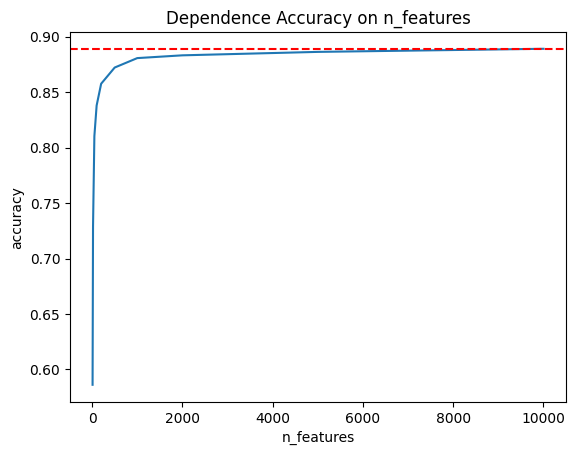

In [24]:
plt.plot(n_features_list, score_list)
plt.axhline(score_list[-1], color = 'red', linestyle = '--')
plt.title('Dependence Accuracy on n_features')
plt.xlabel('n_features')
plt.ylabel('accuracy')
plt.show()

Качество довольно быстро выходит на плато, значит совсем необязательно большое количество n_features

__3__

__Вывод:__ в целом по качеству довольно хорошо и у logrega и svm, у svm чуть получше, но обучается дольше

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [35]:
n_features = 1000
X = x_train
d = X.shape[1]
m = math.ceil(n_features / d)
intercept_ = []
weights_ = []
for i in range(m):
    G = np.random.normal(0,1, (d, d))    # Gaussian matrix
    intercept_ += [np.random.uniform(-np.pi, np.pi, d)]
    Q, _ = np.linalg.qr(G)    # Q from QR-decomposition of G
    S = np.diagflat(np.sqrt(np.random.chisquare(d, d)))    # diag values from chi with dof = d
    weights_ += [S @ Q]

In [136]:
class OFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', kernel = 'rbf'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X_fit = X.copy()
        if self.use_PCA == True:
            self.dec = PCA(self.new_dim)
            X_fit = self.dec.fit_transform(X_fit)
        
        indices = np.random.randint(0, X_fit.shape[0], size=(1000000, 2))
        X_pairs = X_fit[indices]
        sigma = np.sqrt(np.median(np.sum(np.square(X_pairs[:, 0] - X_pairs[:, 1]), axis = 1)))

        d = self.n_features // X_fit.shape[1]

        self.w = []
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
        for _ in range(d):
            G = np.random.normal(0, 1, size=(X_fit.shape[1], X_fit.shape[1]))
            Q, R = np.linalg.qr(G)
            S = np.diag(np.sqrt(np.random.chisquare(X_fit.shape[1], X_fit.shape[1])))
            W = (1 / sigma) * S @ Q
            self.w.append(W)
        
        self.w = np.vstack(self.w)
        X_fit = X_fit[:, :self.n_features]
        self.phi = np.cos(X_fit @ self.w.T + self.b)
        
        if self.classifier == 'logreg':
            self.model = LogisticRegression(max_iter = 100000)
        if self.classifier == 'svm':
            self.model = SVC(kernel = self.kernel, max_iter = 100000)
        self.model.fit(self.phi, y)

        return self


    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_pred = X.copy()
        if self.use_PCA == True:
            X_pred = self.dec.transform(X_pred)

        X_pred = X_pred[:, :self.n_features]
        phi = np.cos(X_pred @ self.w.T + self.b)

        return self.model.predict_proba(phi)
        
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_pred = X.copy()

        if self.use_PCA == True:
            X_pred = self.dec.transform(X_pred)

        X_pred = X_pred[:, :self.n_features]    
        phi = np.cos(X_pred @ self.w.T + self.b)
        
        return self.model.predict(phi)

In [137]:
off = OFFPipeline()
X_fit = off.fit(x_train, y_train)
y_pred = off.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))


Accuracy: 0.8814


In [138]:
off = OFFPipeline(classifier='svm', kernel = 'linear')
X_fit = off.fit(x_train, y_train)
y_pred = off.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

/Users/ASUS/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.8803


In [139]:
off = OFFPipeline(classifier='svm', kernel = 'rbf')
X_fit = off.fit(x_train, y_train)
y_pred = off.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))


Accuracy: 0.8675


__Вывод:___ качество получилось лучше, чем у rff, считается приблизительно столько же

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [28]:
class RFFPipelineCustomFunc(RFFPipeline):
    def __init__(self, function = np.cos, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.function = function
    
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X_fit = X.copy()
        if self.use_PCA == True:
            self.dec = PCA(self.new_dim)
            X_fit = self.dec.fit_transform(X_fit)
        
        indices = np.random.randint(0, X_fit.shape[0], size=(1000000, 2))
        X_pairs = X_fit[indices]
        sigma = np.sqrt(np.median(np.sum(np.square(X_pairs[:, 0] - X_pairs[:, 1]), axis = 1)))

        self.w = np.random.normal(0, (1 / sigma), [X_fit.shape[1], self.n_features])
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
        phi = self.function(X_fit @ self.w + self.b)

        if self.classifier == 'logreg':
            self.model = LogisticRegression(max_iter = 100000)
        if self.classifier == 'svm':
            self.model = SVC(kernel = self.kernel, max_iter = 100000)
        self.model.fit(phi, y)

        return self
    
    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_pred = X.copy()
        if self.use_PCA == True:
            X_pred = self.dec.transform(X_pred)

        phi = self.function(X_pred @ self.w + self.b)

        return self.model.predict_proba(phi)

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_pred = X.copy()

        if self.use_PCA == True:
            X_pred = self.dec.transform(X_pred)

        phi = self.function(X_pred @ self.w + self.b)
        return self.model.predict(phi)
    

In [29]:
rff_abs = RFFPipelineCustomFunc(np.abs)
rff_abs.fit(x_train, y_train)
y_pred = rff_abs.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8692


In [30]:
rff_tanh = RFFPipelineCustomFunc(np.tanh)
rff_tanh.fit(x_train, y_train)
y_pred = rff_tanh.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8732


In [31]:
rff_exp = RFFPipelineCustomFunc(np.exp)
rff_exp.fit(x_train, y_train)
y_pred = rff_exp.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8752


/Users/ASUS/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


__Вывод:__ в целом результаты довольно близки к тому, что у косинуса были, если увеличить max_iter у np.exp, то качество может станет еще лучше

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w + b - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [3]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm
import matplotlib.pyplot as plt

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,         
        lr=0.01,
        regularization=0.1,
        tolerance=1e-3,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1,
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None
        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return 0.5 * np.linalg.norm(self.kernel_ @ self.w + self.b - y) + 0.5 * self.regularization * self.w.T @ self.kernel_ @ self.w 

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        batch_indices = np.random.randint(0, x.shape[0], self.batch_size)
        
        kernel_batch = self.kernel(x[batch_indices], x)
        return kernel_batch.T @ kernel_batch @ self.w - + kernel_batch.T @ np.ones((self.batch_size, 1)) * 1 +  kernel_batch.T @ y[batch_indices] + self.regularization * self.kernel_ @ self.w, np.mean(self.b + kernel_batch @ self.w - y[batch_indices])
    
    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_grad(x, y))
    
    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        weight_difference = -self.lr * gradient[0]
        self.w = self.w + weight_difference[0]
        self.b = self.b - self.lr * gradient[1]
        return weight_difference

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        self.w = np.random.rand(x.shape[0]).reshape(x.shape[0], 1)
        self.b = np.random.rand(1).reshape(-1, 1)
        self.kernel_ = self.kernel(x)
        for _ in tqdm(range(self.max_iter)):
            self.loss_history.append(self.calc_loss(x, y).item())
            delta = self.step(x, y)
            if np.linalg.norm(delta)**2  < self.tolerance:
                break

        self.loss_history.append(self.calc_loss(x, y).item())
        return self

    def predict(self, x_train, x_test: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        return self.kernel(x_train, x_test).T @ self.w + self.b

In [4]:
import scipy.stats as sts
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
import pandas as pd

In [9]:
def generate_correlated_data(correlation, n_samples, n_features, taska):
    np.random.seed(322)
    
    X_base = np.random.normal(loc=0, scale=1, size=n_samples)
    
    df_features = pd.DataFrame(X_base, columns=['base_feature'])
    for i in range(1, n_features + 1):
        noise = np.random.normal(loc=0, scale=(1 - correlation ** 2)  ** 0.5, size=n_samples)
        df_features[f'feature_{i}'] = X_base * correlation + noise
    
    if taska == 'classification':

        y = pd.qcut(X_base, q=10, labels=False)
    elif taska == 'regression':
        y = X_base + np.random.normal(loc=0, scale=0.5, size=n_samples)
        
    
    X_train, X_test, y_train, y_test = train_test_split(df_features.values, y, test_size=0.2, random_state=42)
    
    correlation_matrix = np.corrcoef(X_train.T)
    
    return X_train, X_test, y_train, y_test, correlation_matrix



correlation = 0.9 #тут вставляем корреляцию
n_observations = 1000
n_feat = 1000
taska = 'classification'

X_train_corr, X_test_corr, y_train_corr, y_test_corr, correlation_matrix = generate_correlated_data(correlation, n_observations, n_feat, taska)

print("Первые пять строк матрицы корреляций:")
print(correlation_matrix[:5, :5])

Первые пять строк матрицы корреляций:
[[1.         0.90338652 0.89297273 0.89196328 0.8907343 ]
 [0.90338652 1.         0.81643574 0.79689683 0.81229991]
 [0.89297273 0.81643574 1.         0.78855243 0.7960388 ]
 [0.89196328 0.79689683 0.78855243 1.         0.80647691]
 [0.8907343  0.81229991 0.7960388  0.80647691 1.        ]]


/var/folders/mr/q050g7h96kl_k_qkx4dkzjl00000gn/T/ipykernel_11935/912548847.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f'feature_{i}'] = X_base * correlation + noise
/var/folders/mr/q050g7h96kl_k_qkx4dkzjl00000gn/T/ipykernel_11935/912548847.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f'feature_{i}'] = X_base * correlation + noise
/var/folders/mr/q050g7h96kl_k_qkx4dkzjl00000gn/T/ipykernel_11935/912548847.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

In [11]:
from sklearn.kernel_ridge import KernelRidge

# Assuming X_train_corr, X_test_corr, y_train_corr, y_test_corr are provided

# Initialize KRR model
krr_model = KernelRidge(kernel='rbf')  # You can choose other kernels as well

# Fit the model
krr_model.fit(X_train_corr, y_train_corr)

# Predict on the test set
y_pred_corr = krr_model.predict(X_test_corr)

# Evaluate the model if needed
# For example, you can use mean squared error for regression tasks
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_corr, y_pred_corr)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.10529733420764575


In [18]:
y_train_corr = y_train_corr.reshape(-1, 1)
y_test_corr = y_test_corr.reshape(-1, 1)
krr = KernelRidgeRegression()
krr.fit(X_train_corr, y_train_corr)
y_pred_corr = krr.predict(X_train_corr, X_test_corr)
print('MSE:', mean_squared_error(y_pred_corr, y_test_corr))

100%|██████████| 1000/1000 [00:25<00:00, 38.72it/s]

MSE: 8.773312277915771


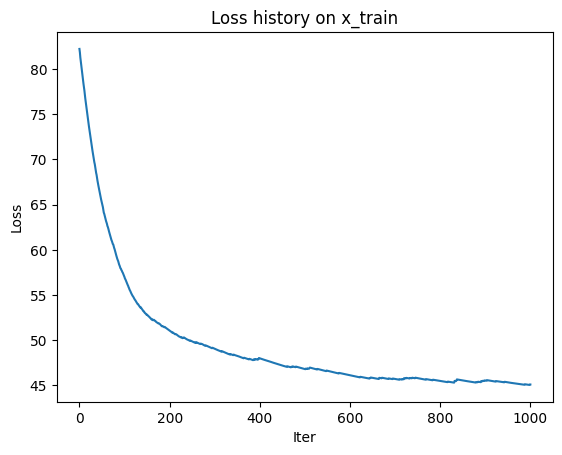

In [19]:
plt.plot(krr.loss_history, label = 'krr')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.title('Loss history on x_train')
plt.show()

In [420]:
X = sts.norm.rvs(size=[10000, 20])
y = sts.norm.rvs(size=[10000, 1])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

krr = KernelRidgeRegression()
krr.fit(x_train, y_train)
y_pred = krr.predict(x_train, x_test)
print('MSE:', mean_squared_error(y_pred, y_test))

100%|██████████| 1000/1000 [08:09<00:00,  2.04it/s]


MSE: 1.0191065972192404


In [417]:
rff = RFFPipeline(classifier = 'linreg', use_PCA=False)
rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
print('MSE:', mean_squared_error(y_pred, y_test))

MSE: 1.1534297739055308


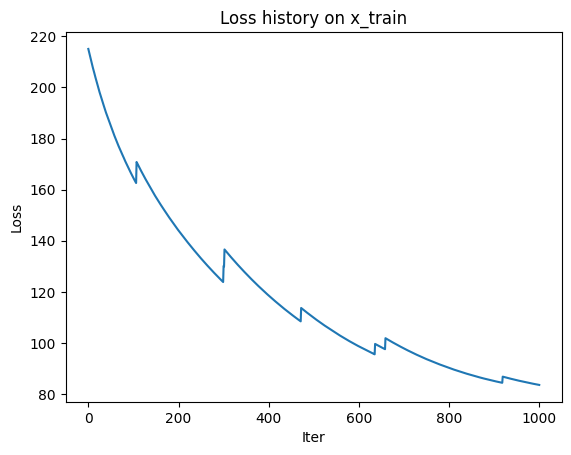

In [421]:
plt.plot(krr.loss_history, label = 'krr')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.title('Loss history on x_train')
plt.show()

__Вывод:__ У krr качество оказалось лучше, чем у rff, но считает оно дольше